In [1]:
# --- Environment setup ---
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

from pathlib import Path
from typing import Dict, List

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score


In [2]:
# --- Configuration ---
# Blocks for Beijing-Changping
BLOCKS = ["回龙观", "霍营", "沙河", "天通苑"]

# File mapping per block (使用 GitHub raw 链接)
PRICE_FILES = {
    "回龙观": "https://raw.githubusercontent.com/Ricaardolin/homework-for-quant/main/HW3/house_data/hlg_fang_esf.csv",
    "霍营": "https://raw.githubusercontent.com/Ricaardolin/homework-for-quant/main/HW3/house_data/hy_fang_esf.csv",
    "沙河": "https://raw.githubusercontent.com/Ricaardolin/homework-for-quant/main/HW3/house_data/shahe_fang_esf.csv",
    "天通苑": "https://raw.githubusercontent.com/Ricaardolin/homework-for-quant/main/HW3/house_data/tty_fang_esf.csv",
}
RENT_FILES = {
    "回龙观": "https://raw.githubusercontent.com/Ricaardolin/homework-for-quant/main/HW3/house_data/hlg_fang_rent.csv",
    "霍营": "https://raw.githubusercontent.com/Ricaardolin/homework-for-quant/main/HW3/house_data/hy_fang_rent.csv",
    "沙河": "https://raw.githubusercontent.com/Ricaardolin/homework-for-quant/main/HW3/house_data/shahe_fang_rent.csv",
    "天通苑": "https://raw.githubusercontent.com/Ricaardolin/homework-for-quant/main/HW3/house_data/tty_fang_rent.csv",
}
# Expected column names (Chinese)
PRICE_COLS = ["名称", "面积(m²)", "小区", "总价(万)", "单价(元/m²)"]
RENT_COLS  = ["名称", "面积(m²)", "月租金(元)"]

# Plot style
sns.set(style="whitegrid", context="talk")
plt.rcParams["figure.figsize"] = (10, 6)


In [3]:
def load_price_block(block, path, encoding="utf-8"):
    """
    加载二手房价格数据，自动识别并统一列名。
    统一后的列名: 名称, 面积(m²), 小区, 总价(万), 单价(元/m²), price/m², block
    """
    df = pd.read_csv(path, encoding=encoding)
    df = df.rename(columns=lambda c: c.strip())  # 去掉首尾空格
    
    # 常见列名映射
    rename_map = {
        "面积(㎡)": "面积(m²)",
        "建筑面积": "面积(m²)",
        "单价(元/㎡)": "单价(元/m²)",
        "单价": "单价(元/m²)"
    }
    df = df.rename(columns=rename_map)
    
    # 如果缺少单价列，就自己算
    if "单价(元/m²)" not in df.columns and {"总价(万)", "面积(m²)"}.issubset(df.columns):
        df["单价(元/m²)"] = df["总价(万)"] * 10000 / df["面积(m²)"]
    
    # 保留需要的列
    keep_cols = ["名称", "面积(m²)", "小区", "总价(万)", "单价(元/m²)"]
    df = df[[c for c in keep_cols if c in df.columns]].copy()
    
    # 统一计算 price/m²
    df["price/m²"] = df["单价(元/m²)"]
    df["block"] = block
    return df.dropna(subset=["面积(m²)", "price/m²"])


def load_rent_block(block, path, encoding="utf-8"):
    """
    加载租房数据，自动识别并统一列名。
    统一后的列名: 名称, 面积(m²), 月租金(元), rent/m², block
    """
    df = pd.read_csv(path, encoding=encoding)
    df = df.rename(columns=lambda c: c.strip())
    
    # 常见列名映射
    rename_map = {
        "面积(㎡)": "面积(m²)",
        "建筑面积": "面积(m²)",
        "租金(元)": "月租金(元)",
        "租金": "月租金(元)"
    }
    df = df.rename(columns=rename_map)
    
    # 保留需要的列
    keep_cols = ["名称", "面积(m²)", "月租金(元)"]
    df = df[[c for c in keep_cols if c in df.columns]].copy()
    
    # 计算 rent/m²
    df["rent/m²"] = df["月租金(元)"] / df["面积(m²)"]
    df["block"] = block
    return df.dropna(subset=["面积(m²)", "rent/m²"])




def concat_all_blocks(files_map: Dict[str, str], loader_func) -> pd.DataFrame:
    """Concatenate dataframe of all blocks using the given loader (支持 URL)."""
    frames = []
    for b, url in files_map.items():
        frames.append(loader_func(b, url))
    return pd.concat(frames, axis=0, ignore_index=True)


def iqr_outlier_mask(series: pd.Series, k: float = 1.5) -> pd.Series:
    """Return boolean mask for outliers using IQR rule."""
    q1, q3 = series.quantile(0.25), series.quantile(0.75)
    iqr = q3 - q1
    lower, upper = q1 - k * iqr, q3 + k * iqr
    return (series < lower) | (series > upper)
# --- IQR 异常值检测函数 ---
def remove_outliers_iqr(df, col, k=1.5):
    """基于 IQR 剔除异常值"""
    q1, q3 = df[col].quantile(0.25), df[col].quantile(0.75)
    iqr = q3 - q1
    lower, upper = q1 - k*iqr, q3 + k*iqr
    return df[(df[col] >= lower) & (df[col] <= upper)]

def set_chinese_font():
    """
    自动检测系统中可用的中文字体，并设置为 Matplotlib 默认字体。
    """
    # 常见中文字体关键字
    candidates = ["Microsoft YaHei", "SimHei", "SimSun", "KaiTi", "FangSong", "STHeiti", "PingFang SC"]
    
    # 系统字体列表
    available_fonts = set(f.name for f in fm.fontManager.ttflist)
    
    # 找到第一个可用的中文字体
    for font in candidates:
        if font in available_fonts:
            plt.rcParams['font.sans-serif'] = [font]
            plt.rcParams['axes.unicode_minus'] = False
            print(f"已设置 Matplotlib 中文字体为: {font}")
            return font
    
    print("⚠️ 未找到常见中文字体，可能仍无法显示中文。请手动安装中文字体。")
    return None

set_chinese_font()

已设置 Matplotlib 中文字体为: Microsoft YaHei


'Microsoft YaHei'

In [4]:
# --- Load all price and rent data ---
all_price = concat_all_blocks(PRICE_FILES, load_price_block)
all_rent  = concat_all_blocks(RENT_FILES,  load_rent_block)

# --- Step 1: 异常值剔除 ---
all_price_clean = all_price.groupby("block", group_keys=False).apply(lambda g: remove_outliers_iqr(g, "price/m²"))
all_rent_clean  = all_rent.groupby("block", group_keys=False).apply(lambda g: remove_outliers_iqr(g, "rent/m²"))

print("剔除异常值前后样本量对比：")
print("Price:", all_price.groupby("block").size(), "→", all_price_clean.groupby("block").size())
print("Rent :", all_rent.groupby("block").size(), "→", all_rent_clean .groupby("block").size())

剔除异常值前后样本量对比：
Price: block
回龙观    1200
天通苑    1200
沙河     1200
霍营      456
dtype: int64 → block
回龙观    1193
天通苑    1165
沙河     1143
霍营      448
dtype: int64
Rent : block
回龙观    1200
天通苑    1200
沙河     1200
霍营      629
dtype: int64 → block
回龙观    1135
天通苑    1134
沙河     1124
霍营      585
dtype: int64


In [5]:
# --- Step 2: 在 block 层面聚合 ---
median_price = all_price.groupby("block")["price/m²"].median()
median_rent  = all_rent.groupby("block")["rent/m²"].median()

median_df = pd.DataFrame({
    "median_price/m²": median_price,
    "median_rent/m²": median_rent
})
median_df["median_price_to_rent"] = median_df["median_price/m²"] / median_df["median_rent/m²"]

print("Block-level median stats:")
print(median_df)

Block-level median stats:
       median_price/m²  median_rent/m²  median_price_to_rent
block                                                       
回龙观            39207.0       75.683666            518.037803
天通苑            31714.0       62.500000            507.424000
沙河             44431.0       50.000000            888.620000
霍营             40501.0       73.069307            554.281978


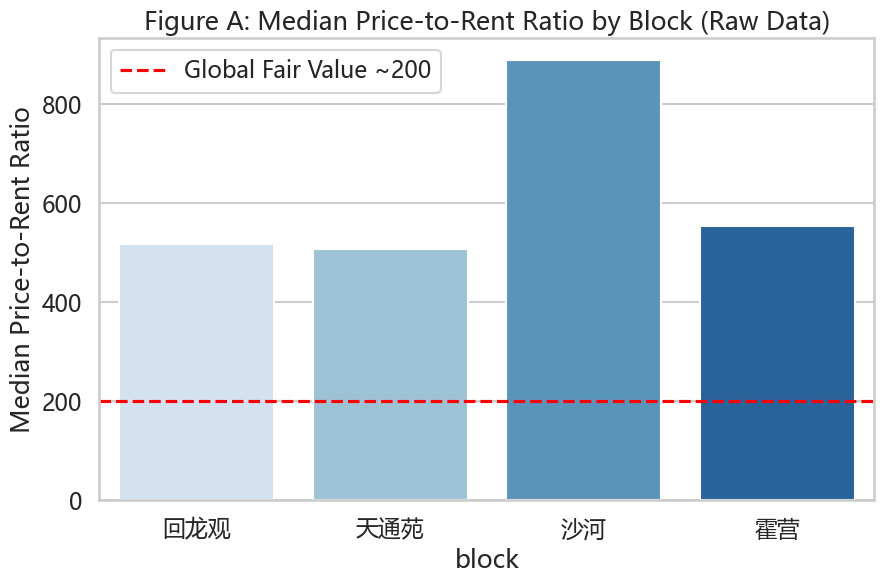

In [6]:
# --- Step 3: Figure A ---
ax = sns.barplot(x=median_df.index, y=median_df["median_price_to_rent"], palette="Blues")
ax.set_ylabel("Median Price-to-Rent Ratio")
ax.set_title("Figure A: Median Price-to-Rent Ratio by Block (Raw Data)")
plt.axhline(200, color="red", linestyle="--", label="Global Fair Value ~200")
plt.legend()
plt.show()


In [7]:
# --- Step 4: 建模 (Model 1 & 2) ---
# 我们在 block 层面建模：用面积的均值作为特征，block 作为分类变量
block_features = all_price.groupby("block")["面积(m²)"].median().to_frame("median_area")
block_features["median_price/m²"] = median_price
block_features["median_rent/m²"]  = median_rent

# 简单线性回归：price/m² ~ area
X = block_features[["median_area"]].values
y_price = block_features["median_price/m²"].values
y_rent  = block_features["median_rent/m²"].values

lr_price = LinearRegression().fit(X, y_price)
lr_rent  = LinearRegression().fit(X, y_rent)

block_features["pred_price/m²_M1"] = lr_price.predict(X)
block_features["pred_rent/m²_M2"]  = lr_rent.predict(X)
block_features["ptr_M12"] = block_features["pred_price/m²_M1"] / block_features["pred_rent/m²_M2"]

print("\nModel 1 & 2 predictions:")
print(block_features[["pred_price/m²_M1","pred_rent/m²_M2","ptr_M12"]])


Model 1 & 2 predictions:
       pred_price/m²_M1  pred_rent/m²_M2     ptr_M12
block                                               
回龙观        37456.309009        71.204132  526.041230
天通苑        38337.251566        67.760377  565.776830
沙河         43090.080135        49.180763  876.157213
霍营         36969.359290        73.107701  505.683517


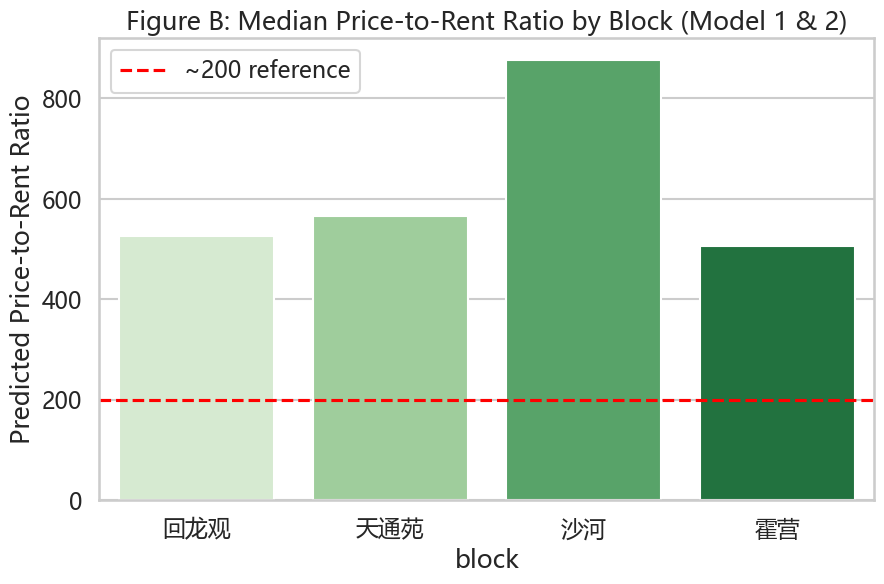

In [8]:
# --- Step 5: Figure B ---
ax = sns.barplot(x=block_features.index, y=block_features["ptr_M12"], palette="Greens")
ax.set_ylabel("Predicted Price-to-Rent Ratio")
ax.set_title("Figure B: Median Price-to-Rent Ratio by Block (Model 1 & 2)")
plt.axhline(200, color="red", linestyle="--", label="~200 reference")
plt.legend()
plt.show()


In [9]:
# --- Step 6: 扩展模型 (Model 1+ & 2+) ---
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

lr_price_plus = LinearRegression().fit(X_poly, y_price)
lr_rent_plus  = LinearRegression().fit(X_poly, y_rent)

block_features["pred_price/m²_M1+"] = lr_price_plus.predict(X_poly)
block_features["pred_rent/m²_M2+"]  = lr_rent_plus.predict(X_poly)
block_features["ptr_M1+M2+"] = block_features["pred_price/m²_M1+"] / block_features["pred_rent/m²_M2+"]

print("\nModel 1+ & 2+ predictions:")
print(block_features[["pred_price/m²_M1+","pred_rent/m²_M2+","ptr_M1+M2+"]])



Model 1+ & 2+ predictions:
       pred_price/m²_M1+  pred_rent/m²_M2+  ptr_M1+M2+
block                                                 
回龙观         37591.096965         71.281327  527.362475
天通苑         32395.858986         64.357645  503.372349
沙河          44407.171743         49.935083  889.298051
霍营          41458.872306         75.678918  547.825912


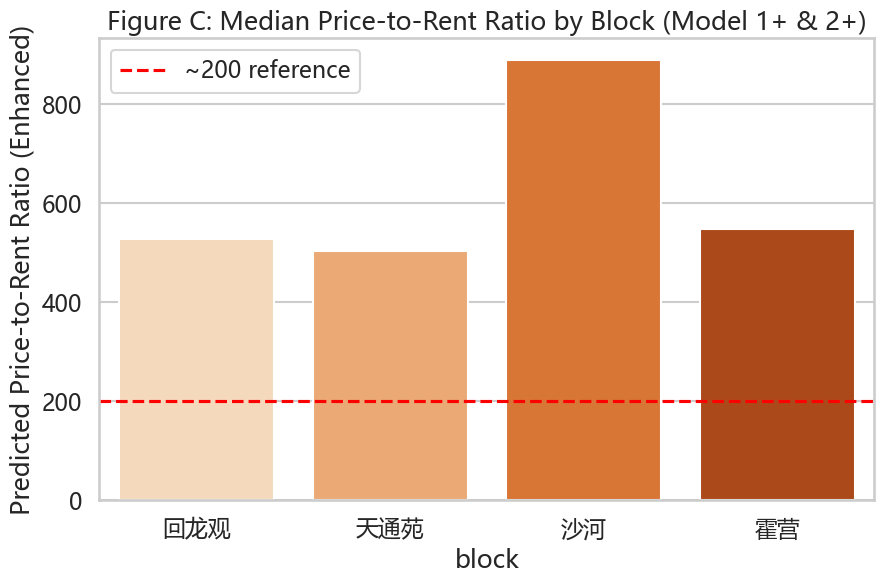

In [10]:
# --- Step 7: Figure C ---
ax = sns.barplot(x=block_features.index, y=block_features["ptr_M1+M2+"], palette="Oranges")
ax.set_ylabel("Predicted Price-to-Rent Ratio (Enhanced)")
ax.set_title("Figure C: Median Price-to-Rent Ratio by Block (Model 1+ & 2+)")
plt.axhline(200, color="red", linestyle="--", label="~200 reference")
plt.legend()
plt.show()


In [24]:
# --- Step 8: 汇总比较 ---
comparison = pd.DataFrame({
    "Raw Median": median_df["median_price_to_rent"],
    "Model1&2": block_features["ptr_M12"],
    "Model1+&2+": block_features["ptr_M1+M2+"]
})
print("\nComparison of Price-to-Rent Ratios:")
print(comparison)
 # 经验规则：样本量>=30时，Raw Median 更稳健
print("\n考虑到样本量较大，由经验知Raw Median 更可信。")


Comparison of Price-to-Rent Ratios:
       Raw Median    Model1&2  Model1+&2+
block                                    
回龙观    518.037803  526.041230  527.362475
天通苑    507.424000  565.776830  503.372349
沙河     888.620000  876.157213  889.298051
霍营     554.281978  505.683517  547.825912

考虑到样本量较大，由经验知Raw Median 更可信。
